# **Emotion Classification with DistilBERT**

**Author**: Leen Kharboutli

**Acknowledgment**: This notebook is based on code from a notebook by Adriana Salcedo. You can find the original notebook [here](https://www.kaggle.com/code/adrianasalcedo/emotion-w-distilbert/notebook).


In [1]:
import os
import typing
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from datasets import load_dataset
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# **Config**

In [2]:
dataset_folder_path = './raw_data/twitter_emotion/'
model = 'distilbert-base-uncased'
num_labels = 6 
batch_size =  64
model_save_path = './distelbert-for-emotion-classification'

label_encoder_path = 'label_encoder.pkl'
raw_lyrics_dataset_path = './lyrics_text.csv'
predicted_lyrics_classification_dataset_path = 'lyrics_with_emotion_preds_exp.csv'

# Set this to True if you wish to save notebook outputs, False otherwise.
overwrite_save = False

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model)

In [4]:
le = LabelEncoder()

# **Functions**

In [5]:
def tokenize(data):
    """
    Tokenize and truncate the input text data.

    Args:
        data (dict): Input data containing text to be tokenized.
    
    Requires:
        tokenizer (AutoTokenizer): tokenizer configured for model.

    Returns:
        BatchEncoding: Tokenized and truncated data.
    """
    return tokenizer(
        data["text"], padding=True, truncation=True, return_tensors="tf"
    )

def extract_hidden_states(batch):
    """
    Extracts the hidden states from a batch of text inputs using a
    pre-trained BERT model.

    Args:
        batch (dict): A dictionary containing a key "text" with a
        list of text inputs.

    Requires:
        model (str): model name.
        tokenizer (AutoTokenizer): tokenizer configured for model.

    Returns:
        dict: A dictionary with a key "hidden_states" containing
        the numpy array of hidden states for the [CLS] token.
    """
    
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    bert_model = TFAutoModel.from_pretrained(model)
    outputs = bert_model(inputs)
    hidden_states = outputs.last_hidden_state[:, 0].numpy()
    return {"hidden_states": hidden_states}

def confusion_matrix_plot(
    y_pred: np.ndarray, y_true: np.ndarray, labels: typing.List[str], clf: str
) -> None:
    """
    Create and display confusion matrix.

    Args:
        y_pred (np.ndarray): Predicted labels.
        y_true (np.ndarray): True labels.
        labels (list): List of labels.
        clf (str): Classifier name.
    """
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    confm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    confm.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title(f"Normalized confusion matrix {clf}")
    plt.show()

def evaluate_model(
    y_true: np.ndarray, y_pred: np.ndarray
) -> typing.Dict[str, float]:
    """
    Evaluate the model using accuracy and F1 score.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        dict: Dictionary containing accuracy and F1 score.
    """
    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "f1": f1}

def extract_labels(features, labels):
    """
    Extract true labels from the dataset.

    Args:
        features (Any): Input features.
        labels (Any): True labels.

    Returns:
        Any: True labels.
    """
    return labels

def tokenize_truncate(data):
    """
    Truncate if token length exceeds max_length.

    Args:
        data (dict): Input data containing text to be tokenized.

    Requires:
        tokenizer (AutoTokenizer): tokenizer configured for model.
    
    Returns:
        transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast:
            configured tokenizer.
    """
    max_length = 512
    return tokenizer(
        data["text"],
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf",
    )


# **Load Data**

In [6]:
datasets = {}
for dirname, _, filenames in os.walk(dataset_folder_path):
    for filename in filenames:
        filename_title = filename.split('.txt')[0]
        filename_path = os.path.join(dirname, filename)
        datasets[filename_title] = filename_path
        print(filename_path)

./raw_data/twitter_emotion/test.txt
./raw_data/twitter_emotion/train.txt
./raw_data/twitter_emotion/val.txt


In [7]:
datasets

{'test': './raw_data/twitter_emotion/test.txt',
 'train': './raw_data/twitter_emotion/train.txt',
 'val': './raw_data/twitter_emotion/val.txt'}

# **Visualize Data**

In [8]:
train_ds = pd.read_csv(datasets['train'], delimiter=";", names=["text", "label"])

val_ds = pd.read_csv(datasets['val'], delimiter=";", names=["text", "label"])

test_ds = pd.read_csv(datasets['test'], delimiter=";", names=["text", "label"])

In [9]:
train_ds

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [10]:
val_ds

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [11]:
test_ds

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


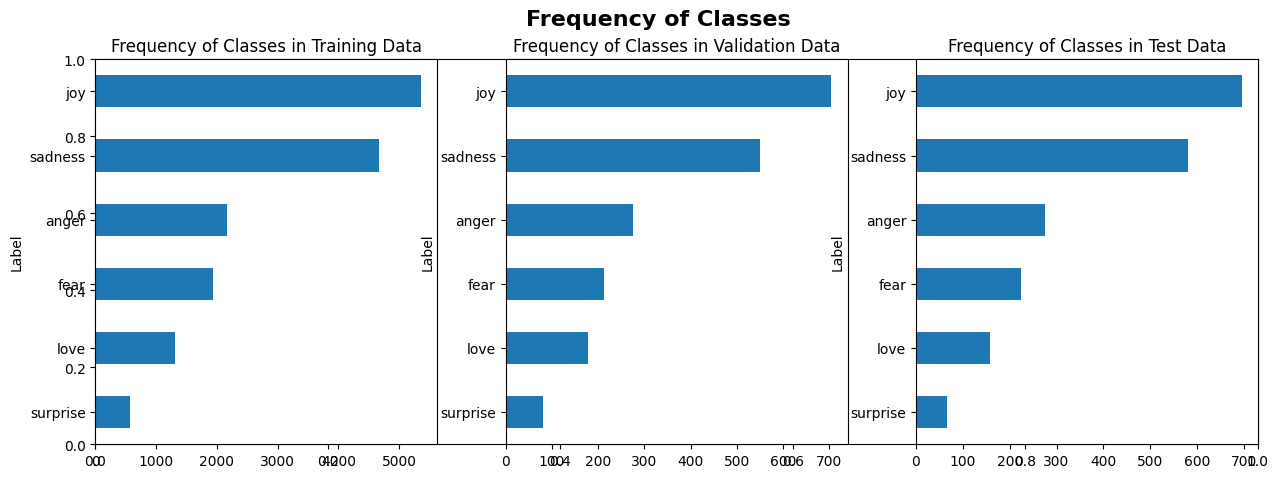

In [12]:
plt.subplots(figsize=(15,5))

plt.subplot(1,3,1)
train_ds["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in Training Data")
plt.ylabel("Label")

plt.subplot(1,3,2)
val_ds["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in Validation Data")
plt.ylabel("Label")

plt.subplot(1,3,3)
test_ds["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in Test Data")
plt.ylabel("Label")

plt.suptitle("Frequency of Classes", fontsize=16, fontweight='bold')
plt.show()


In [13]:
# Concat Train and Val Set to get a better overview of the dataset
emotions = pd.concat([train_ds, val_ds], axis=0)

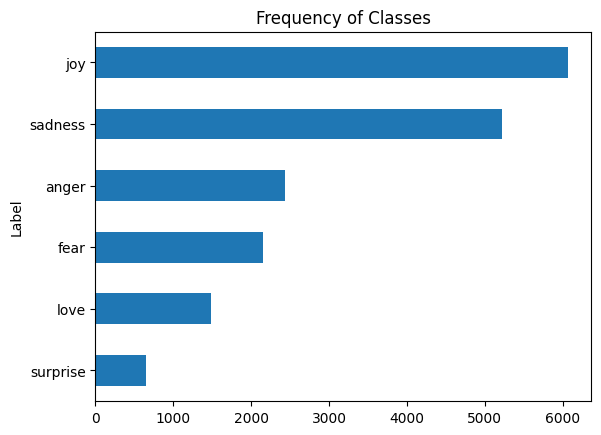

In [14]:
emotions["label"].value_counts(ascending=True).plot.barh()
plt.ylabel("Label")
plt.title("Frequency of Classes")
plt.show()

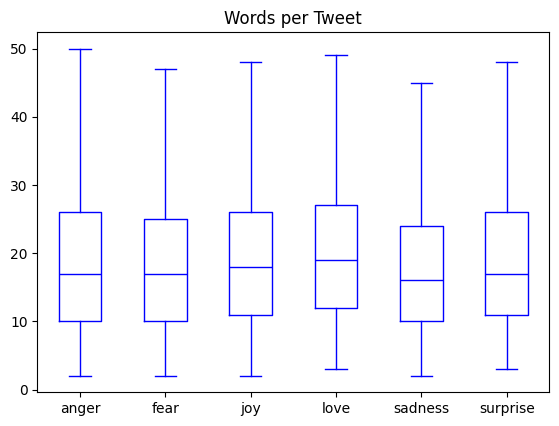

In [15]:
emotions["Words per Tweet"] = emotions["text"].str.split().apply(len)
emotions.boxplot("Words per Tweet", by="label", grid=False, showfliers=False, color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show()

# **Prep Data for DistilBERT**

Loading Datasets again but this time as a Dict

In [16]:
emotions_train = load_dataset("csv", data_files=datasets['train'], delimiter=";", names=["text", "label"])
emotions_val = load_dataset("csv", data_files=datasets['val'], delimiter=";", names=["text", "label"])
emotions_test = load_dataset("csv", data_files=datasets['test'], delimiter=";", names=["text", "label"])

In [17]:
emotions_train

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [18]:
emotions_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [19]:
emotions_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [20]:
labels = np.unique(emotions_train["train"]["label"])

## **Tokenization**

In [21]:
emotions_train_encoded = emotions_train.map(tokenize, batched = True, batch_size = None) # token encodings train set

emotions_val_encoded = emotions_val.map(tokenize, batched = True, batch_size = None) # token encodings validation set

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
emotions_train_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
})

In [23]:
emotions_val_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# **Train and Test Two Other Classifier Models on Twitter Dataset For Comparison**

## 1. Feature Extraction and Data Prep

In [24]:
# Get hidden States for Feature Extraction 
train_hidden_states = emotions_train_encoded.map(extract_hidden_states, batched=True)
val_hidden_states = emotions_val_encoded.map(extract_hidden_states, batched=True) 

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.

In [25]:
train_hidden_states

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_states'],
        num_rows: 16000
    })
})

In [26]:
val_hidden_states

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_states'],
        num_rows: 2000
    })
})

In [27]:
X_train = np.array(train_hidden_states["train"]["hidden_states"])
X_val = np.array(val_hidden_states["train"]["hidden_states"])

In [28]:
y_train = np.array(train_hidden_states["train"]["label"])
y_val = np.array(val_hidden_states["train"]["label"])

In [29]:
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)

## 2. Visualize the Training Set in 2D 

In [30]:
X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.220225,6.756186,4
1,-3.095513,6.721987,4
2,5.333017,3.276018,0
3,-2.571893,4.668110,3
4,-3.492264,4.830262,0


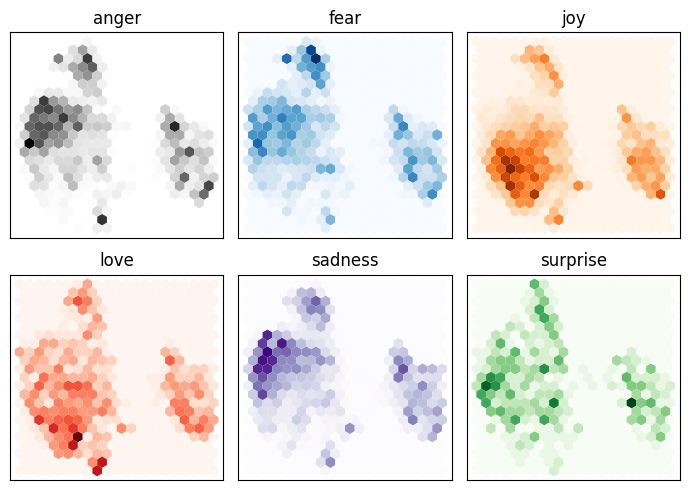

In [31]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label=={i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                  gridsize=20, linewidth=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## 3. Fit XGB and Logistic Regression Classifiers

In [32]:
xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)

xgb_clf.score(X_val, y_val)

0.59

In [33]:
log_clf = LogisticRegression(max_iter=3000)

log_clf.fit(X_train, y_train)

log_clf.score(X_val, y_val)

0.6345

## 4. Evaluation

In [34]:
model1 = "XGBoost Classifier"
model2 = "Logistic Regression"

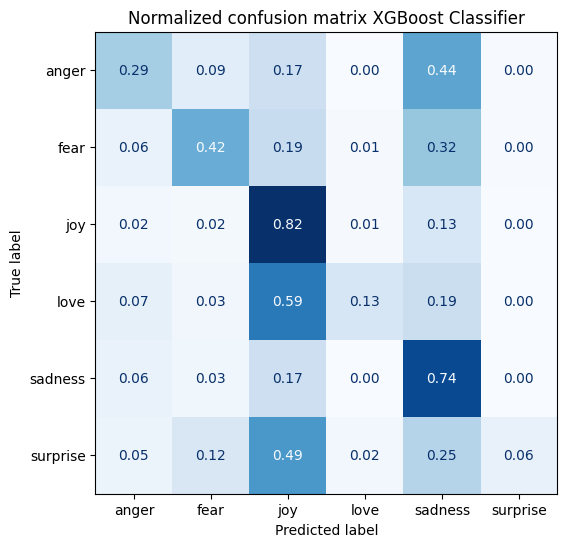

In [35]:
# XGB Classifier Confusion Matrix

y_pred_xgb = xgb_clf.predict(X_val)
confusion_matrix_plot(y_pred_xgb, y_val, labels, model1)

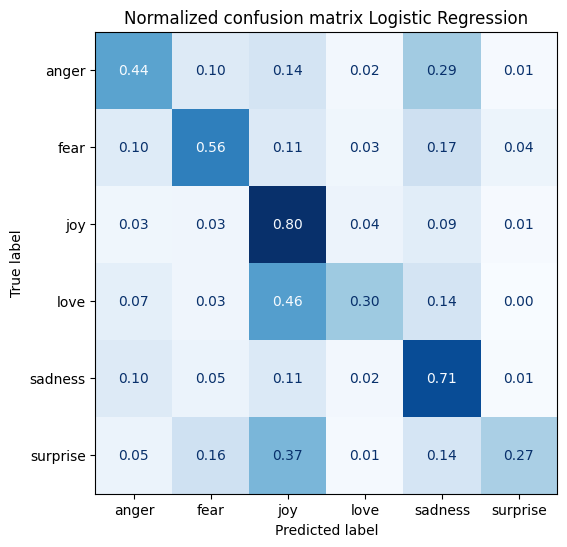

In [36]:
# Logistic Regression Confusion Matrix

y_pred_log = log_clf.predict(X_val)
confusion_matrix_plot(y_pred_log, y_val, labels, model2)

# **Fine-Tune Pre-Trained DistilBERT Model**

## 1. Load Pre-Trained DistilBERT Model

In [37]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model, num_labels=num_labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## 2. Label Encoding and Data Prep

In [38]:
labels_train = emotions_train_encoded["train"]["label"]
labels_val = emotions_val_encoded["train"]["label"]

label_encoded_train = le.fit_transform(labels_train)
emotions_train_encoded["train"] = emotions_train_encoded["train"].add_column("encoded_label", label_encoded_train)

label_encoded_val = le.fit_transform(labels_val)
emotions_val_encoded["train"] = emotions_val_encoded["train"].add_column("encoded_label", label_encoded_val)

In [39]:
tokenizer_columns = tokenizer.model_input_names 

tf_train =  emotions_train_encoded["train"].to_tf_dataset(columns=tokenizer_columns, label_cols=["encoded_label"], 
                                                          shuffle=True, 
                                                          batch_size=batch_size)

tf_val = emotions_val_encoded["train"].to_tf_dataset(columns=tokenizer_columns, label_cols=["encoded_label"], 
                                                     shuffle=False, 
                                                     batch_size=batch_size)

c:\Users\Leen\projects\lyric-sentiment-analysis\venv311\Lib\site-packages\datasets\arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


### Save the encoder

In [40]:
if overwrite_save:
    with open(label_encoder_path, 'wb') as file:
        pickle.dump(le, file)

## 3. Fit the Model and Predict

In [41]:
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [42]:
tf_model.fit(tf_train, validation_data=tf_val, epochs=3)

Epoch 1/3
250/250 [==============================] - 1524s 6s/step - loss: 0.5300 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.2042 - val_sparse_categorical_accuracy: 0.9260
Epoch 2/3
250/250 [==============================] - 1397s 6s/step - loss: 0.1489 - sparse_categorical_accuracy: 0.9398 - val_loss: 0.1559 - val_sparse_categorical_accuracy: 0.9280
Epoch 3/3
250/250 [==============================] - 1593s 6s/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.1643 - val_sparse_categorical_accuracy: 0.9360


In [43]:
y_pred_tf = tf_model.predict(tf_val)

32/32 [==============================] - 57s 2s/step


## 4. Evaluate the Model

In [44]:
# Predicted Labels from Model

logits = y_pred_tf.logits
y_pred = np.argmax(logits, axis=1)

print("Predicted Labels:", y_pred)

Predicted Labels: [4 4 3 ... 2 2 2]


In [45]:
# Get true Labels

y_true = tf_val.map(extract_labels)
y_true = tf.concat(list(y_true.as_numpy_iterator()), axis=0)

print(y_true)

tf.Tensor([4 4 3 ... 2 2 2], shape=(2000,), dtype=int64)


In [46]:
evaluate_model(y_true, y_pred)

{'accuracy': 0.936, 'f1': 0.9362844095791549}

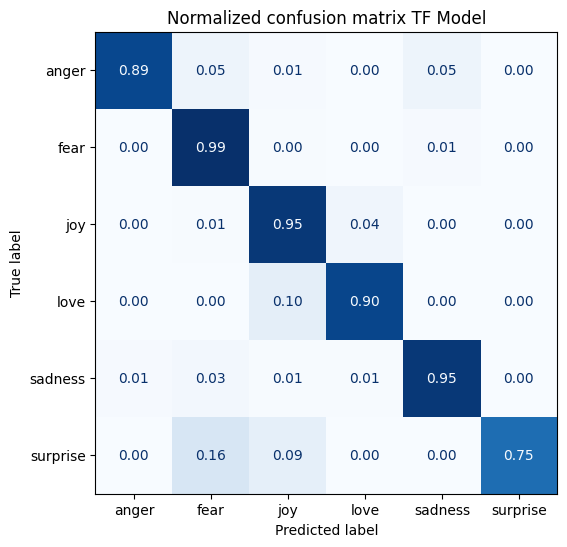

In [47]:
# Confusion Matrix
confusion_matrix_plot(y_pred, y_true, labels, "TF Model")


In [48]:
# Display some examples

for i in range(20):
    predicted_label_index = y_pred[i]
    predicted_label = emotions_train["train"]["label"][predicted_label_index]
    true_label_index = int(y_true[i])
    true_label = le.inverse_transform([true_label_index])

    print(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}\nText: {emotions_val_encoded['train']['text'][i]}\n\n")
    

Predicted Label: anger
True Label: ['sadness']
Text: im feeling quite sad and sorry for myself but ill snap out of it soon


Predicted Label: anger
True Label: ['sadness']
Text: i feel like i am still looking at a blank canvas blank pieces of paper


Predicted Label: love
True Label: ['love']
Text: i feel like a faithful servant


Predicted Label: sadness
True Label: ['anger']
Text: i am just feeling cranky and blue


Predicted Label: anger
True Label: ['joy']
Text: i can have for a treat or if i am feeling festive


Predicted Label: anger
True Label: ['joy']
Text: i start to feel more appreciative of what god has done for me


Predicted Label: anger
True Label: ['joy']
Text: i am feeling more confident that we will be able to take care of this baby


Predicted Label: anger
True Label: ['joy']
Text: i feel incredibly lucky just to be able to talk to her


Predicted Label: anger
True Label: ['joy']
Text: i feel less keen about the army every day


Predicted Label: anger
True Label: ['sa

## 5. Save Model and Tokenizer

In [49]:
if overwrite_save:
    # (OPTIONAL) Save fine-tuned distilBERT model and associated tokenizer
    # Save the entire model (architecture + weights + optimizer state)
    tf_model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

## NOTE: Reload model with the following code:
# tf_model = TFAutoModelForSequenceClassification.from_pretrained(
#     model_save_path, num_labels=num_labels
# )
# tokenizer = AutoTokenizer.from_pretrained(model_save_path)

# **Predicting Emotion Label on Lyrics**

## 1. Prep Lyrics Data

In [50]:
lyrics_test_data = load_dataset("csv", data_files=raw_lyrics_dataset_path, delimiter=",", names=["text"]) # Might have to amend the delimiter, based on how we write the data, and will the test break if I don't have labels? 

In [51]:
lyrics_test_data

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 28372
    })
})

In [52]:
lyrics_test_encoded = lyrics_test_data.map(tokenize_truncate, batched = True, batch_size = None) 

In [53]:
lyrics_test_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 28372
    })
})

In [54]:
tokenizer_columns = tokenizer.model_input_names 
tf_lyrics = lyrics_test_encoded["train"].to_tf_dataset(columns=tokenizer_columns, # label_cols=["encoded_label"], 
                                                     shuffle=False, 
                                                     batch_size=batch_size)

## 2. Use Fine-Tuned DistilBERT Model to Perform Emotion Classification on Lyrics Dataset

In [55]:
lyrics_y_pred_tf = tf_model.predict(tf_lyrics)

444/444 [==============================] - 7938s 18s/step


In [56]:
lyrics_y_pred_tf

TFSequenceClassifierOutput(loss=None, logits=array([[-2.5134401 ,  0.11191288, -1.7609369 , -1.7755066 ,  5.322768  ,
        -1.8018774 ],
       [-1.5624307 , -0.8364545 ,  4.1734233 , -1.2251672 ,  0.34864774,
        -2.804986  ],
       [-1.677611  , -1.5897783 ,  5.5480785 , -1.6979562 ,  0.24644461,
        -2.8299782 ],
       ...,
       [-2.0676045 , -2.6722286 ,  0.6400899 ,  4.683042  , -0.428081  ,
        -3.0307615 ],
       [-0.8180893 , -2.5983052 ,  4.3332305 ,  0.56843024, -1.8127402 ,
        -1.9467291 ],
       [ 2.996681  ,  2.1180313 , -2.2204654 , -1.7758915 , -1.9150128 ,
        -0.7330335 ]], dtype=float32), hidden_states=None, attentions=None)

## 3. Extract Model Predictions

In [57]:
# Predicted Labels from Model

lyrics_logits = lyrics_y_pred_tf.logits
lyrics_y_pred = np.argmax(lyrics_logits, axis=1)

print("Predicted Labels:", lyrics_y_pred)

Predicted Labels: [4 2 2 ... 3 2 0]


In [58]:
len(lyrics_y_pred)

28372

In [59]:
encoding_dict = dict(zip(le.transform(le.classes_), le.classes_))

In [60]:
# Display some examples

for i in range(len(lyrics_y_pred)):

    if i > 10:
        break

    predicted_label_index = lyrics_y_pred[i]
    predicted_label = encoding_dict[predicted_label_index]

    print(f"Predicted Label: {predicted_label}\nText: {lyrics_test_encoded['train']['text'][i]}\n\n")

Predicted Label: sadness
Text: hold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little turn dust play house ruin run leave save like chase train late late tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little run leave save like chase train know late late play break string feel heart want feel tell real truth hurt lie worse anymore little know little hold time feel


Predicted Label: joy
Text: believe drop rain fall grow believe darkest night candle glow believe go astray come believe believe believe smallest prayer hear believe great hear word time hear bear baby touch leaf believe believe believe lord heaven guide sin hide believe calvary die pierce believe death rise meet heaven loud amen know believe


Predicted Label: joy
Text: sweetheart send letter goodbye secret feel better wake dream think real

## 4. Save Model Predictions for Analysis

In [61]:
lyrics_text = lyrics_test_encoded['train']['text']

In [62]:
predicted_lyrics_labels = [encoding_dict[val] for val in lyrics_y_pred]

In [63]:
lyrics_df = pd.DataFrame({
                            'lyrics_text':lyrics_text,
                            'predicted_emotion_label':  predicted_lyrics_labels,
                            'predicted_encoded_label': lyrics_y_pred
                          })
lyrics_df.head()

,lyrics_text,predicted_emotion_label,predicted_encoded_label
0,hold time feel break feel untrue convince spea...,sadness,4
1,believe drop rain fall grow believe darkest ni...,joy,2
2,sweetheart send letter goodbye secret feel bet...,joy,2
3,kiss lips want stroll charm mambo chacha merin...,joy,2
4,till darling till matter know till dream live ...,joy,2


In [64]:
if overwrite_save:
    lyrics_df.to_csv(predicted_lyrics_classification_dataset_path)

Copyright 2024 Adriana Salcedo

Copyright 2024 Leen Kharboutli

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.